# Seasonality of NDVI across Australia




In [1]:
import sys
import folium
import warnings
import xarray as xr
import pandas as pd
import seaborn as sb
import geopandas as gpd
import xarray as xr
from scipy import stats
import contextily as ctx
import numpy as np
import scipy.signal
import contextily as ctx
import matplotlib.pyplot as plt
from xarrayMannKendall import Mann_Kendall_test

import odc.geo.xr
from odc.geo.geobox import zoom_out
from odc.geo.xr import assign_crs

# sys.path.append('/g/data/os22/chad_tmp/climate-carbon-interactions/src')
# from _trends import linregress

sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import round_coords

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize
from dea_tools.temporal import xr_phenology
# from dea_tools.spatial import subpixel_contours

In [2]:
# sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
# from dask_utils import start_local_dask

# client = start_local_dask(mem_safety_margin='2Gb')
# client

## Analysis Parameters

Start with 5km resolution datasets to speed up exploration

In [3]:
var='NDVI'
ds_path = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/LGBM/NDVI_CLIM_LGBM_5km_monthly_1982_2022_noGaps.nc'
# er_path = '/g/data/os22/chad_tmp/climate-carbon-interactions/results/predictions/ER_1982_2022_5km_LGBM_20230911.nc'
# gpp_path = '/g/data/os22/chad_tmp/climate-carbon-interactions/results/predictions/GPP_1982_2022_5km_LGBM_20230911.nc'
# nee_path = '/g/data/os22/chad_tmp/climate-carbon-interactions/results/predictions/NEE_1982_2022_5km_LGBM_20230911.nc'
# et_path = '/g/data/os22/chad_tmp/climate-carbon-interactions/results/predictions/ET_1982_2022_5km_LGBM_20230911.nc'
# ndvi_path = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/NDVI_5km_monthly_1982_2022.nc'

chunks=None#dict(latitude=1000, longitude=1000, time=-1)

t_range='1982', '2022'

#SE AUS
# lat_bounds = slice(355, 590)
# lon_bounds = slice(575,840)

# #All of Aus
# lat_bounds = slice(0, 680)
# lon_bounds = slice(0,840)

## Open data

In [4]:
ds = assign_crs(xr.open_dataset(ds_path, chunks=chunks)[var], crs='EPSG:4326')
ds = ds.sel(time=slice(t_range[0], t_range[1]))

if var=='NDVI':
    ds = ds.rename({'latitude':'y', 'longitude':'x'})

In [5]:
# if var=='NDVI':
#     ndvi_min = 0.141
#     ndvi_max = 0.91
    
#     ds = (ds - ndvi_min) / (ndvi_max - ndvi_min)
#     ds = xr.where(ds<0, 0, ds)
#     ds = xr.where(ds>1, 1, ds)

## Calculate annual phenology statistics

### Smoothing filters

In [6]:
ds_smooth = ds.resample(time="2W").interpolate("linear")

#rolling mean
# ds_smooth_rolling=ds_smooth.rolling(time=6, min_periods=1, center=True).mean()

# # Savitsky-Golay
ds_smooth = xr.apply_ufunc(
        scipy.signal.savgol_filter,
        ds_smooth,
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        kwargs=dict(
            window_length=11,
            polyorder=3,
            deriv=0,
            mode='interp'),
        dask='allowed'
    )
#SG cuts of last 6 months so clip to complete calendar years.
ds_smooth = ds_smooth.sel(time=slice('1982', '2021'))

In [7]:
# ds_smooth.sel(time='2022').plot.imshow(col='time', col_wrap=5)

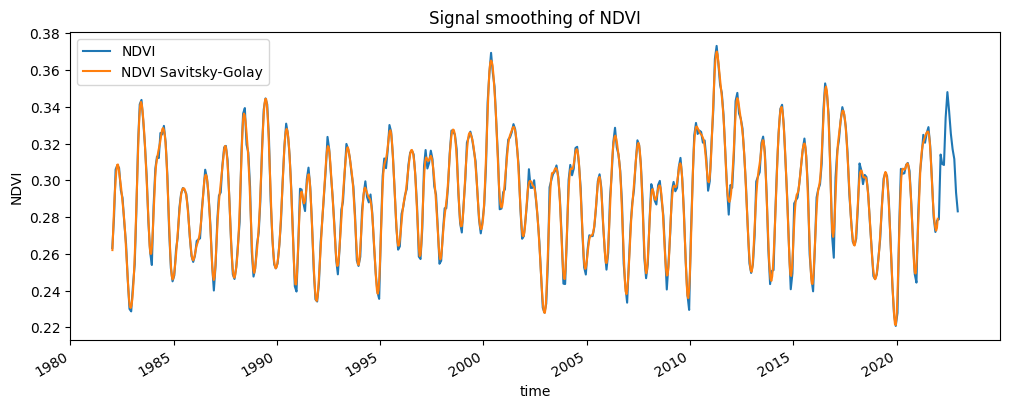

In [8]:
fig,ax=plt.subplots(1,1, figsize=(12,4))
ds.mean(['x', 'y']).plot(ax=ax, label='NDVI')
ds_smooth.mean(['x', 'y']).plot(ax=ax, label='NDVI Savitsky-Golay')
# ds_smooth_rolling.mean(['x', 'y']).plot(ax=ax, label='NDVI rolling')
ax.legend(loc='upper left')
ax.set_title('Signal smoothing of NDVI');

### Phenology

In [9]:
warnings.simplefilter('ignore')
doy = ds_smooth.groupby('time.year').map(xr_phenology)

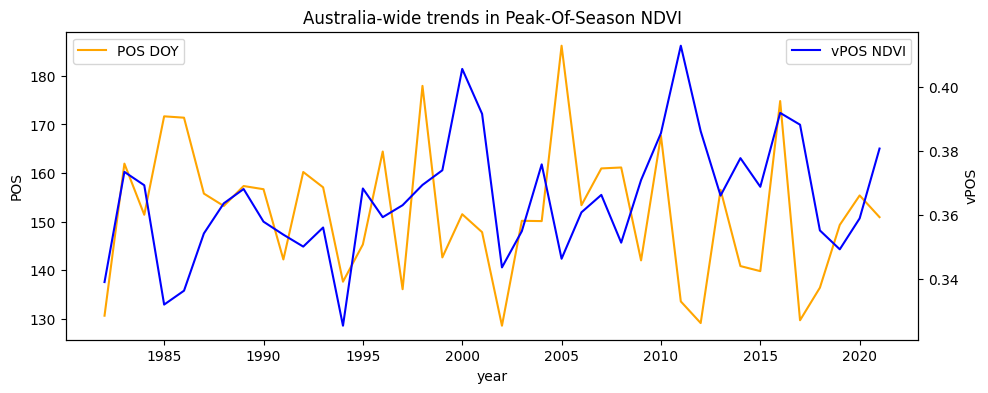

In [10]:
fig,ax=plt.subplots(1,1, figsize=(11,4))
ax2 = ax.twinx()
doy.POS.where(doy['POS']>20).mean(['x', 'y']).plot(ax=ax, c='orange', label='POS DOY')
doy.vPOS.where(doy['POS']>20).mean(['x', 'y']).plot(ax=ax2, c='blue', label='vPOS NDVI')
# doy.AOS.where(doy.AOS>0).mean(['x', 'y']).plot(ax=ax2, label='AOS NDVI')
# doy.Trough.where(doy.AOS>0).mean(['x', 'y']).plot(ax=ax2, label='AOS NDVI')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.set_title('')
ax2.set_title('Australia-wide trends in Peak-Of-Season NDVI');

### Per pixel trends in POS

Use the Mann-Kendall robust regression (this is quite slow)

In [11]:
pos_trends = Mann_Kendall_test(doy['POS'].rename({'year':'time'}),
                               alpha=0.05,
                               method='theilslopes'
                              ).compute()

vpos_trends = Mann_Kendall_test(doy['vPOS'].rename({'year':'time'}),
                               alpha=0.05,
                               method='theilslopes'
                              ).compute()

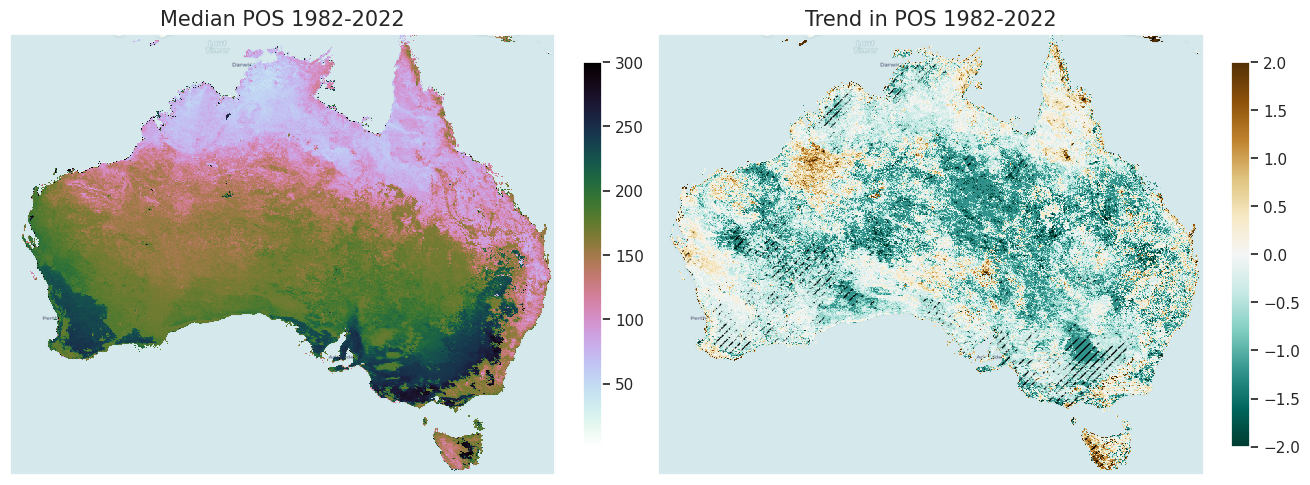

In [32]:
sb.set(font_scale=1.0)
vmin=1
vmax=300
font=15

fig,ax = plt.subplots(1,2, figsize=(13,6), sharex=True, sharey=True, layout='constrained')
for a,i in zip(ax.reshape(-1), range(0,2)):
    if i==0:
        im = doy['POS'].where(doy['POS']>20).median('year').plot(cmap='cubehelix_r',
                                    vmin=vmin, vmax=vmax, ax=a, add_labels=False, add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
        cb = fig.colorbar(im, ax=a, shrink=0.65, orientation='vertical', label='')
        a.set_title('Median POS 1982-2022', fontsize=font)
    
    if i==1:
        # im = pos_trends.trend.plot(vmin=-2,vmax=2, ax=a, add_labels=False, cmap='BrBG_r', add_colorbar=False)
        t = pos_trends.trend.where((pos_trends.trend>-0.02) | (pos_trends.trend<-0.03))
        im = t.plot(vmin=-2, vmax=2, ax=a, add_labels=False, cmap='BrBG_r', add_colorbar=False)
        
        cb = fig.colorbar(im, ax=a, shrink=0.65, orientation='vertical', label='')
        xr.plot.contourf(pos_trends.trend.where(pos_trends.signif), ax=a, alpha=0, hatches=['////'], add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
        a.set_title('Trend in POS 1982-2022', fontsize=font)
    
    a.set_yticklabels([])
    a.set_ylabel('')
    a.set_xlabel('')
    a.set_xticklabels([]);
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/POS_"+var+"_per_pixel_trends.png", bbox_inches='tight', dpi=300)


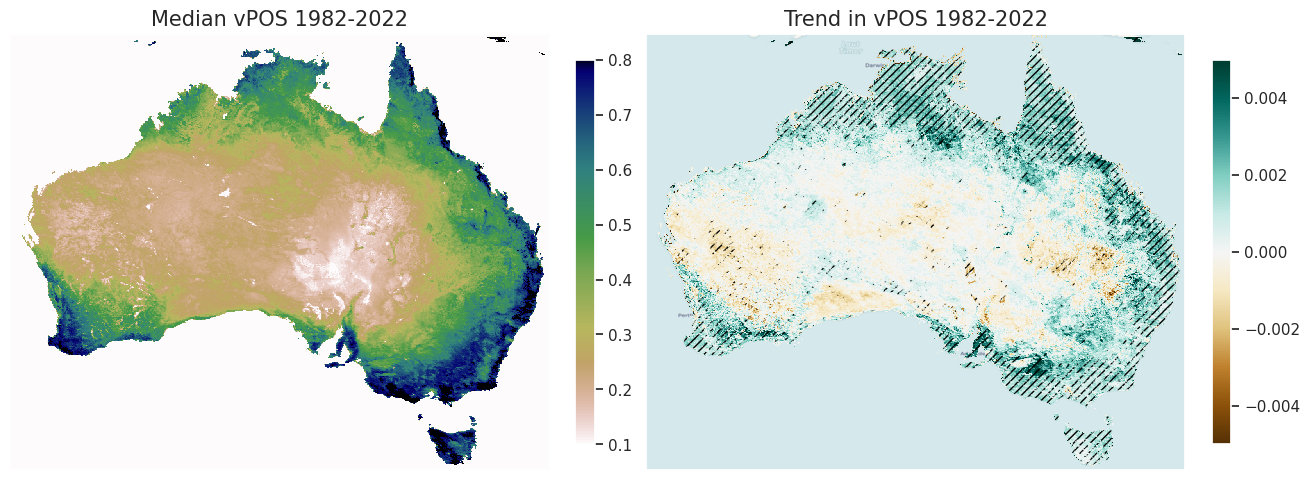

In [13]:
sb.set(font_scale=1.0)
fig,ax = plt.subplots(1,2, figsize=(13,6), sharex=True, sharey=True, layout='constrained')
for a,i in zip(ax.reshape(-1), range(0,2)):
    if i==0:
        im = doy['vPOS'].median('year').plot(cmap='gist_earth_r', vmin=0.1, vmax=0.8, 
                                   ax=a, add_labels=False, add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager,
                        crs='EPSG:4326', attribution='', attribution_size=1)
        cb = fig.colorbar(im, ax=a, shrink=0.65, orientation='vertical', label='')
        a.set_title('Median vPOS 1982-2022', fontsize=font)
    
    if i==1:
        im = vpos_trends.trend.where(vpos_trends.trend!=0).plot(vmin=-0.005,
                                        vmax=0.005, ax=a, add_labels=False, cmap='BrBG', add_colorbar=False)
        cb = fig.colorbar(im, ax=a, shrink=0.65, orientation='vertical', label='')
        xr.plot.contourf(vpos_trends.trend.where(vpos_trends.signif),
                         ax=a, alpha=0, hatches=['////'], add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
        a.set_title('Trend in vPOS 1982-2022', fontsize=font)
    
    a.set_yticklabels([])
    a.set_ylabel('')
    a.set_xlabel('')
    a.set_xticklabels([]);

fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/vPOS_"+var+"_per_pixel_trends.png",
            bbox_inches='tight', dpi=300)

### Trends in POS & vPOS etc. disaggregrated by bioclimatic region

Two ways to do this:
1. Average phenology metrics over the region, then calculate slopes over the aggregated timeseries.
2. Calculate per pixel slopes, then plot the distribution of slopes in the region.


In [14]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

#### The first way

In [15]:
doy_var = [doy]
names = [var]

outer = []
for index, row in gdf.iterrows():
    mask = xr_rasterize(gdf.iloc[[index]], ds.isel(time=1))
    mask = round_coords(mask)
    
    if var=='NDVI':
        mask = mask.rename({'latitude':'y', 'longitude':'x'})
    
    inner = []
    for v,n in zip(doy_var, names):
        var_region = v.where(mask)
        
        doy_df = var_region.POS.mean(['x', 'y']).drop('spatial_ref').to_dataframe()
        doy_df['vPOS'] = var_region.vPOS.mean(['x', 'y']).drop('spatial_ref').to_dataframe()
        
        doy_df['region'] = row['region_name']
        doy_df = doy_df.rename({
            'vPOS':'vPOS ('+var+')',
            'POS':'Peak-Of-Season (DOY)'
                      },   
                      axis=1)
        inner.append(doy_df)
    outer.append(inner)

df=[]
for i in range(0,len(outer)):
    xx = df.append(pd.concat(outer[i]))
df = pd.concat(df)
df = df.reset_index()

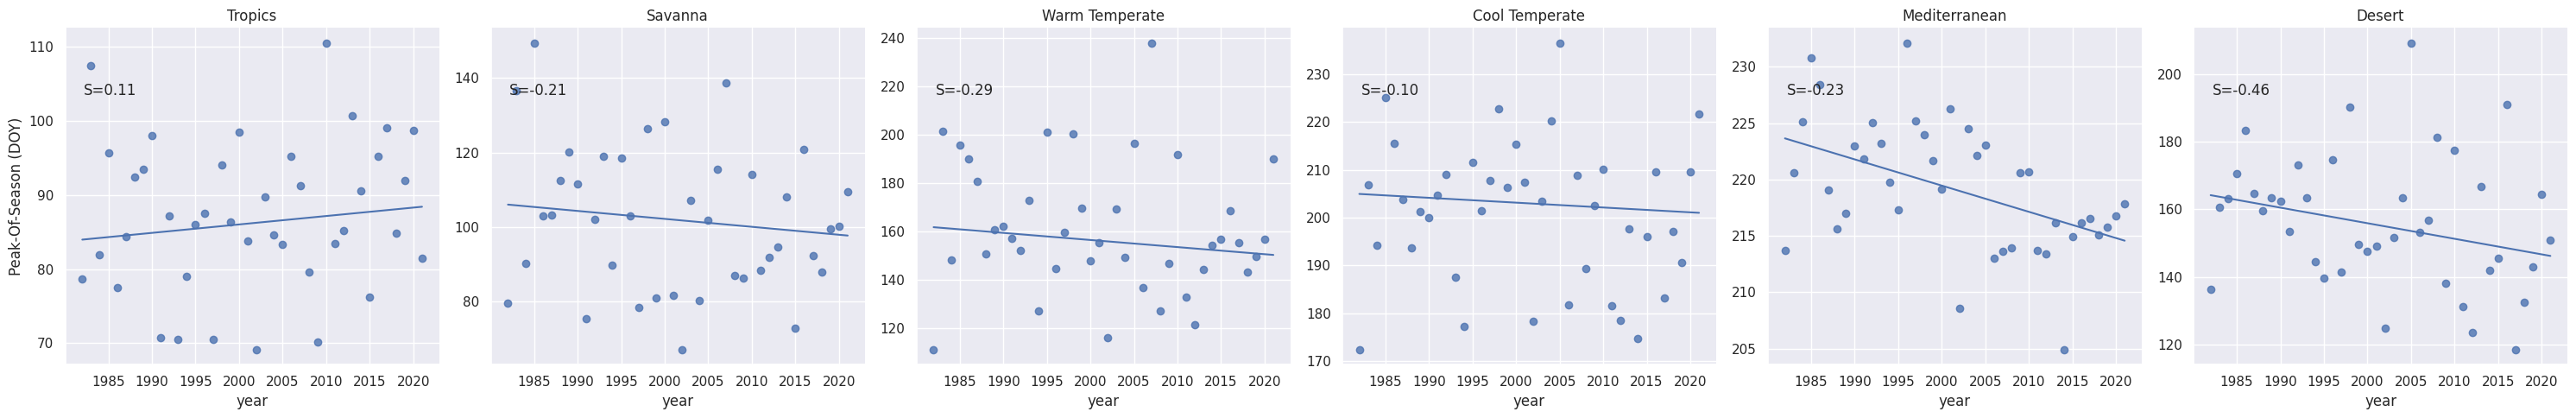

In [16]:
g = sb.lmplot(
    data=df, x="year", y="Peak-Of-Season (DOY)",
    col="region", fit_reg=False, col_wrap=6,
    facet_kws=dict(sharex=True, sharey=False)
)

g.set_titles(col_template="{col_name}", row_template="{row_name}")
def annotate(data, **kws):
    # s, i, r, p, se = stats.linregress(data['year'],data['Peak-Of-Season (DOY)'])
    s, i, l, h =  stats.mstats.theilslopes(data['Peak-Of-Season (DOY)'], data['year']) 
    ax = plt.gca()
    ax.plot(data['year'], i + s * data['year'], 'b-')
    # ax.plot(data['year'], i + l * data['year'], 'r--')
    # ax.plot(data['year'], i + h * data['year'], 'r--')
    ax.text(.05, .8, 'S={:.2f}'.format(s),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)

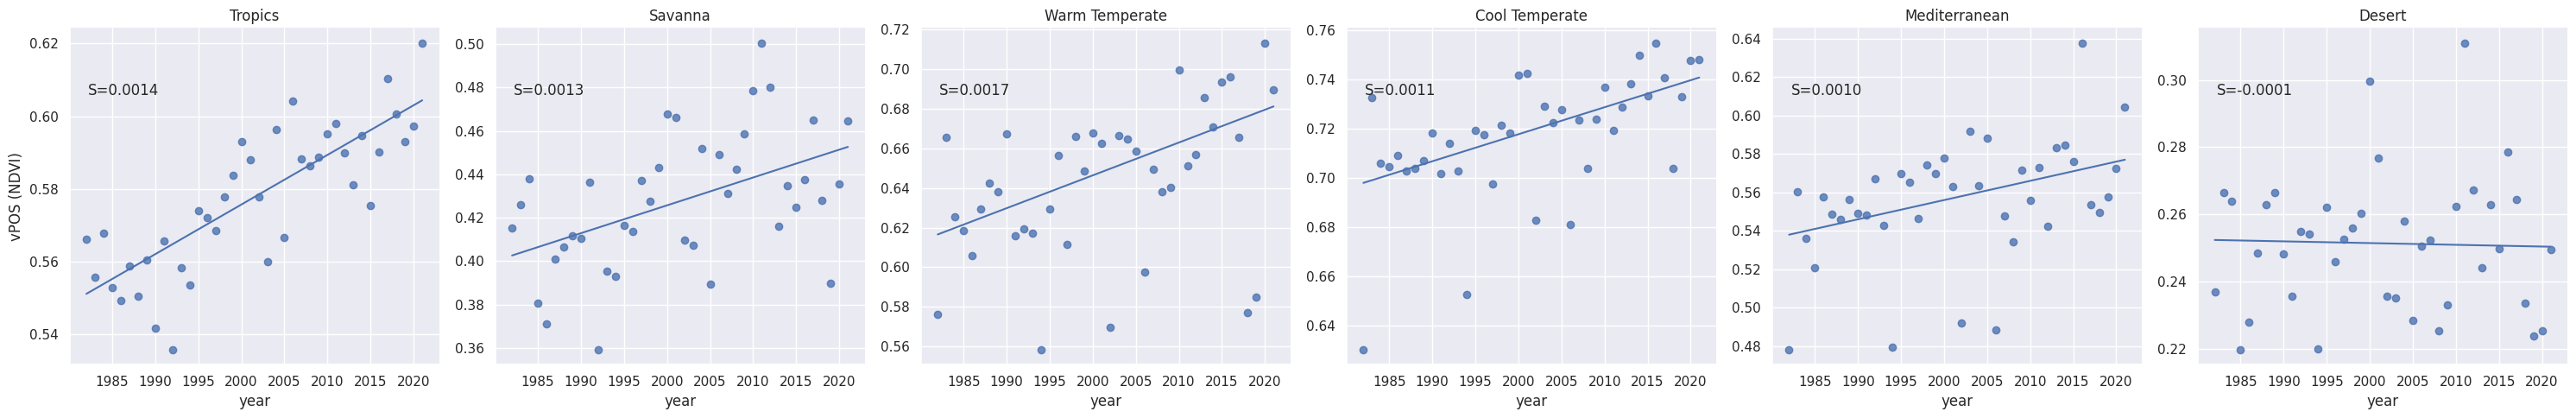

In [17]:
g = sb.lmplot(
    data=df.reset_index(), x="year", y="vPOS (NDVI)",
    col="region", col_wrap=6, fit_reg=False,
    facet_kws=dict(sharex=True, sharey=False)
)

g.set_titles(col_template="{col_name}", row_template="{row_name}")
def annotate(data, **kws):
    # s, i, r, p, se = stats.linregress(data['year'],data['Peak-Of-Season (DOY)'])
    s, i, l, h =  stats.mstats.theilslopes(data['vPOS (NDVI)'], data['year']) 
    ax = plt.gca()
    ax.plot(data['year'], i + s * data['year'], 'b-')
    # ax.plot(data['year'], i + l * data['year'], 'r--')
    # ax.plot(data['year'], i + h * data['year'], 'r--')
    ax.text(.05, .8, 'S={:.4f}'.format(s),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)

#### The second way

In [18]:
doy_var = [pos_trends, vpos_trends]
names = ['POS', 'vPOS']

outer = []
for index, row in gdf.iterrows():
    mask = xr_rasterize(gdf.iloc[[index]], ds.isel(time=1))
    mask = round_coords(mask)
    
    if var=='NDVI':
        mask = mask.rename({'latitude':'y', 'longitude':'x'})
    
    inner = []
    for v,n in zip(doy_var, names):
        var_region = v.where(mask)
        
        doy_df = var_region.drop('spatial_ref').to_dataframe()
        doy_df = doy_df[['trend', 'signif']]
        
        doy_df['region'] = row['region_name']
        doy_df = doy_df.rename({
            'trend':'trend_'+n,
            'signif':'signif_'+n,
                      }, axis=1)
        inner.append(doy_df)
    outer.append(inner)

trends_df=[]
for i in range(0,len(outer)):
    xx = trends_df.append(pd.concat(outer[i]))
trends_df = pd.concat(trends_df).reset_index(drop=True)

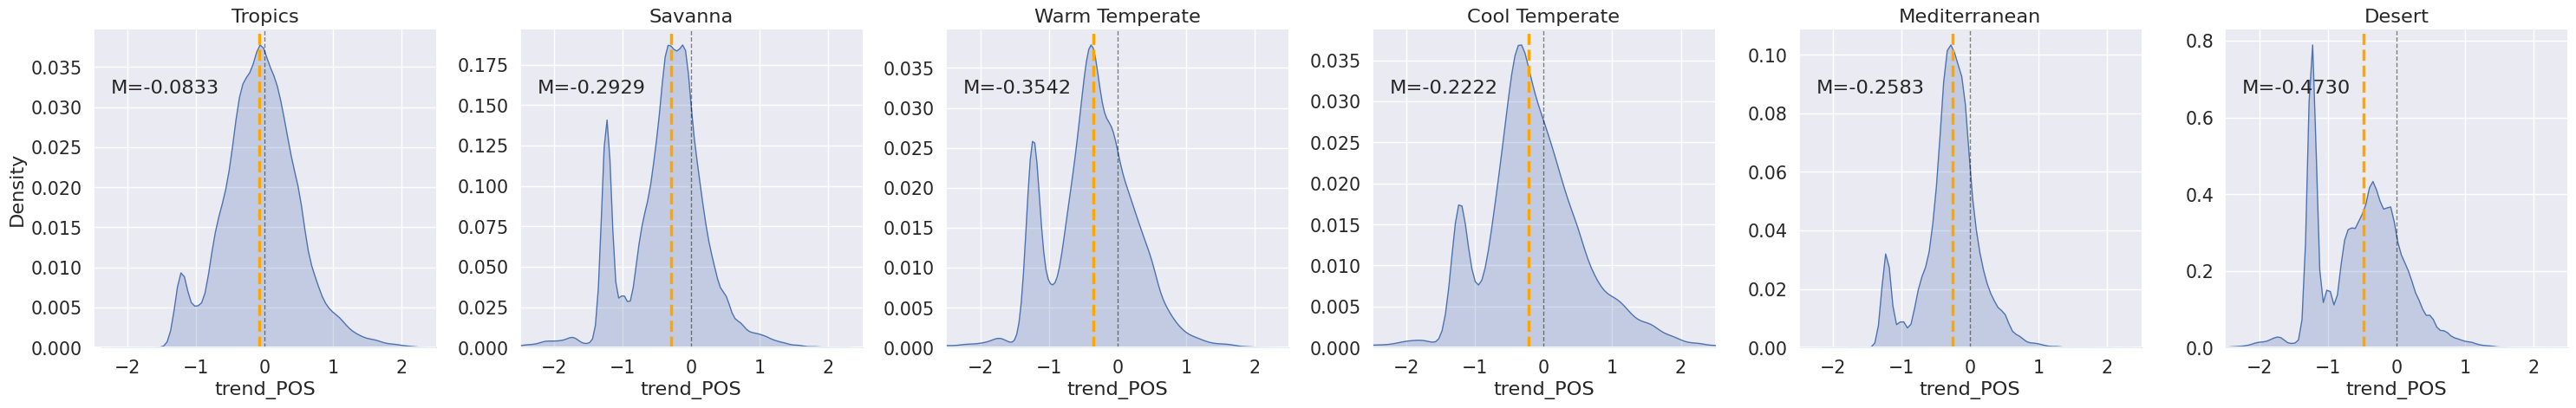

In [19]:
sb.set(font_scale=1.35)

g = sb.displot(trends_df, kind="kde", fill=True, x="trend_POS",
    col="region", col_wrap=6, palette='viridis',
    facet_kws=dict(sharex=True, sharey=False, xlim=(-2.5,2.5))
)

g.set_titles(col_template="{col_name}", row_template="{row_name}")

def specs(x, **kwargs):
    plt.axvline(0, c='black', ls='--', lw=1, alpha=0.5)
    plt.axvline(x.median(), c='orange', ls='--', lw=2.5)
    ax = plt.gca()
    ax.text(.05, .8, 'M={:.4f}'.format(x.median()),
            transform=ax.transAxes)

g.map(specs, "trend_POS")
g.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/POS_"+var+"_bioregion_dist.png",
          bbox_inches='tight', dpi=300);

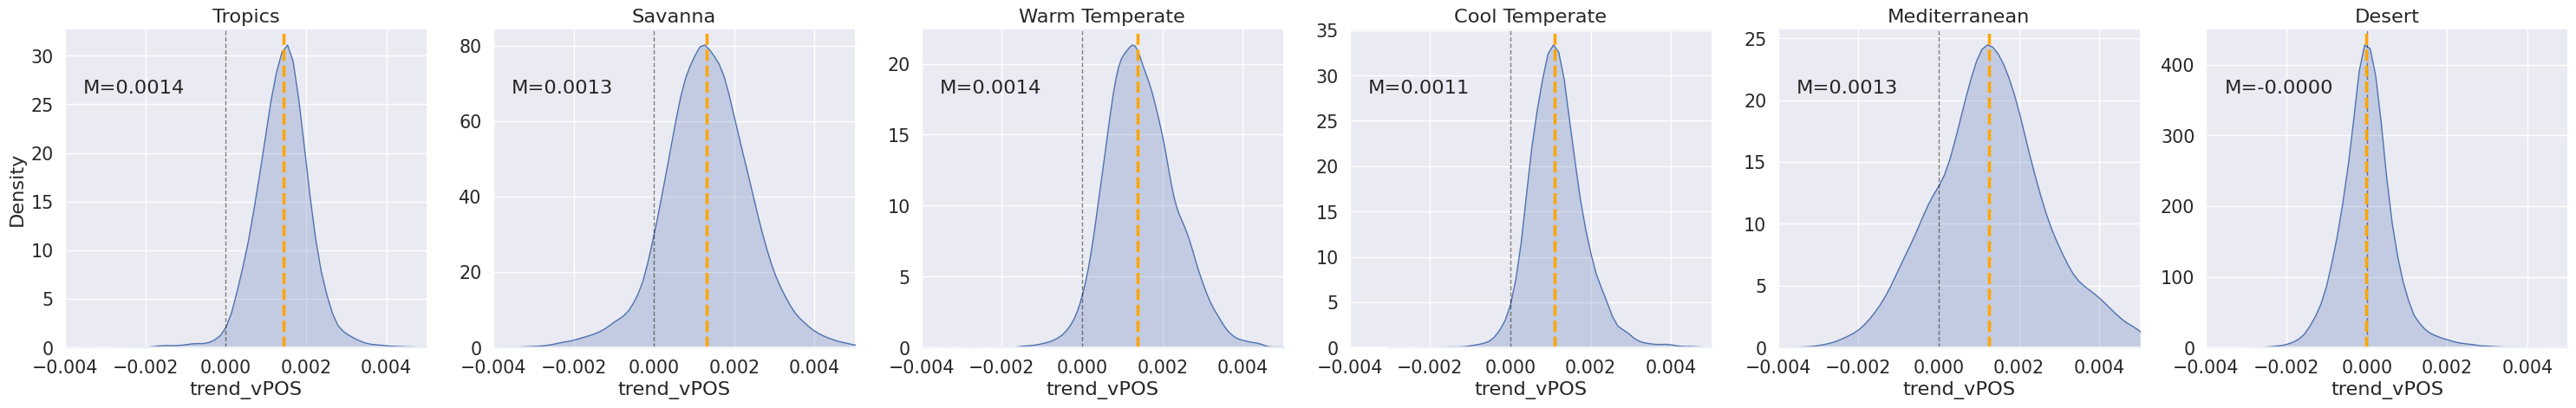

In [20]:
sb.set(font_scale=1.35)

g = sb.displot(trends_df, kind="kde", fill=True, x="trend_vPOS",
    col="region", col_wrap=6, palette='viridis',
    facet_kws=dict(sharex=True, sharey=False, xlim=(-0.004, 0.005))
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")

def specs(x, **kwargs):
    plt.axvline(0, c='black', ls='--', lw=1, alpha=0.5)
    plt.axvline(x.median(), c='orange', ls='--', lw=2.5)
    ax = plt.gca()
    ax.text(.05, .8, 'M={:.4f}'.format(x.median()),
            transform=ax.transAxes)

g.map(specs, "trend_vPOS")
g.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/vPOS_"+var+"_bioregion_dist.png",
          bbox_inches='tight', dpi=300);

## Phenology curves

### Per bioregion

In [21]:
_var = [ds]
names = [var]

outer = []
for index, row in gdf.iterrows():
    mask = xr_rasterize(gdf.iloc[[index]], ds.isel(time=1))
    mask = round_coords(mask)
    if var=='NDVI':
        mask = mask.rename({'latitude':'y', 'longitude':'x'})
    
    inner = []
    for v,n in zip(_var, names):
        ds.name=var
        ds_region = v.where(mask)
        
        early_clim = ds_region.sel(time=slice('1982', '2001')).groupby('time.month').mean()
        late_clim = ds_region.sel(time=slice('2002', '2022')).groupby('time.month').mean()
        
        df = early_clim.mean(['x', 'y']).drop('spatial_ref').to_dataframe()
        df['2002-2022'] = late_clim.mean(['x', 'y']).drop('spatial_ref').to_dataframe()
        df = df.rename({'NDVI':'1982-2001'}, axis=1)
        
        df['region'] = row['region_name']
        # df['Month'] = ["J","F","M","A","M","J","J","A","S","O","N","D"]
        
        inner.append(df)
    outer.append(inner)

dffs=[]
for i in range(0,len(outer)):
    dffs.append(pd.concat(outer[i]))
df_ds_clim = pd.concat(dffs)

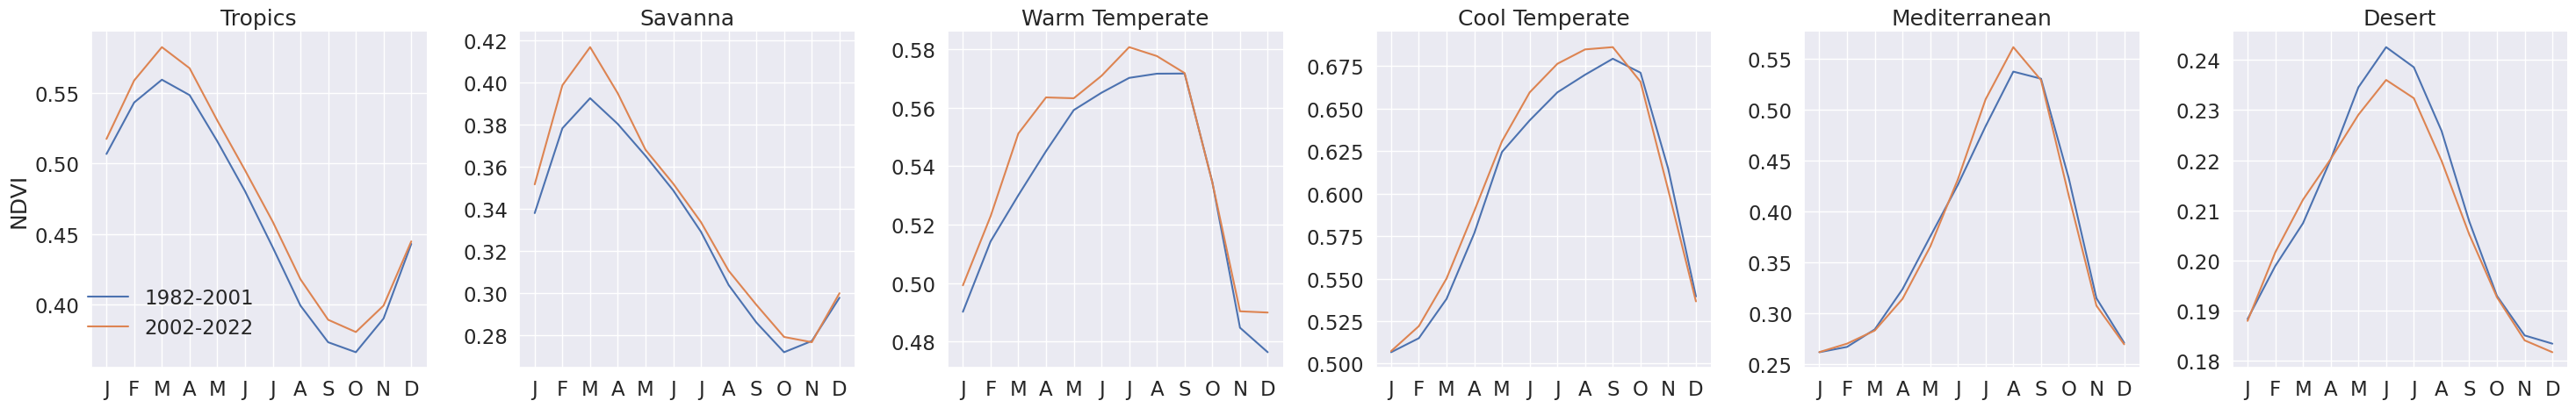

In [22]:
sb.set(font_scale=1.5)
g = sb.relplot(
    data=df_ds_clim.melt(id_vars='region', ignore_index=False, value_name=var, var_name='Climatology Range'),
    x="month",
    y=var,
    col="region",
    hue='Climatology Range',
    col_wrap=6, kind="line", ci=None,
    # palette=sb.color_palette("rocket_r"),
    facet_kws=dict(sharex=True, sharey=False)
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
sb.move_legend(g, "upper center", 
    bbox_to_anchor=(.065, 0.35), ncol=1, title=None, frameon=False)
g.set(xlabel=None)
g.set(xticks=range(1,13))
g.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"]);
g.tight_layout();
g.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/"+var+"_phenology_bioregion.png",
          bbox_inches='tight', dpi=300);

### Australian-wide

In [23]:
early_clim = ds.sel(time=slice('1982', '2001')).groupby('time.month').mean()
late_clim = ds.sel(time=slice('2002', '2022')).groupby('time.month').mean()

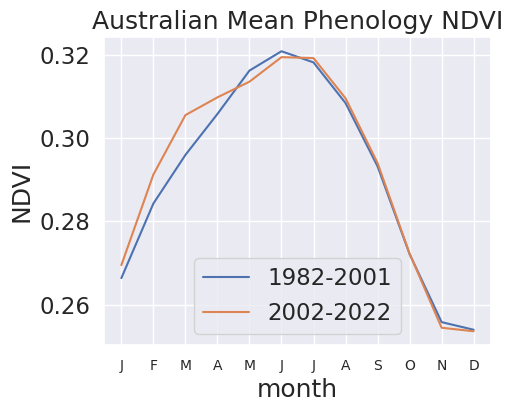

In [24]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
early_clim.mean(['x','y']).plot(label='1982-2001', ax=ax)
late_clim.mean(['x','y']).plot(label='2002-2022', ax=ax)
ax.legend()
plt.title('Australian Mean Phenology '+var)
ax.set(xticks=range(1,13))
ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=10);